# PPI design workflow 

In this example, a putative variant of the spike protein is designed that
evades binding by the antibody THSC20.HVTR26, while still binding ACE2.

## Input information:

* 6m0j.pdb:
    * Chain A: Angiotensin-converting enzyme 2 (UniProt ID: ` Q9BYF1`)
    * Chain E: Spike protein S1 (UniProt ID: `P0DTC2`)

* 7z0x.pdb:
    * Chain H: THSC20.HVTR26 Fab, heavy chain
    * Chain L: THSC20.HVTR26 Fab, light chain
    * Chain R: Spike protein S1 (UniProt ID: `P0DTC2`)


In [1]:
import matplotlib.pyplot as plt
import secstructartist as ssa
from ppidesign import PPITarget, PPIWorkflow

# Define negative target
#   i.e., Target which interactions should be kept/promoted
posTarget = PPITarget("6m0j.pdb", "E", "A")

# Define negative target
#   i.e., Target which interactions should be abrrogated
negTarget = PPITarget("7z0x.pdb", "R", ("H","L"))

# Initialize workflow
workflow = PPIWorkflow(posTarget, negTarget)

## Initial complexes' biophysical properties

In the plot below, the biophysical properties of the wt protein in both complexes
are plotted along the sequence. As the sequences are identical (except the C-terminus) there is practical no difference in the biophysical profile.

The interface regions are highlighted in blue (for the interface to be kept), 
and red (for the interface to be abrogated). The idea now is to alter the 
residues in the non-overlapping red interface such, that the biophysical profile 
in this region changes to an extend that the protein-protein interface is not
functional anymore.

The red interface region is fairly flexible, indicated by higher values in the 
DisoMine score (`disorder > .2`), lower values in the DynaMine score 
(`dynamics < .8`), and high coil propensities.

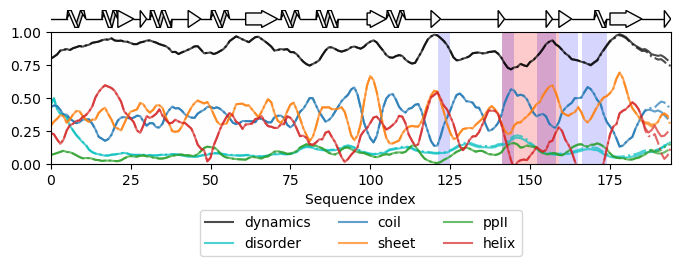

In [2]:
attribute_color = [
    ("dynamics", "k"), ("disorder", "c"), 
    ("coil", "C0"), ("sheet", "C1"), 
    ("ppII", "C2"), ("helix", "C3")
]

# --- Get some properties for the wt protein
#
seqA = workflow.posPdb.get_sequences("pdb-atom")[workflow.posChain]
seqB = workflow.negPdb.get_sequences("pdb-atom")[workflow.negChain]

dfA, dfB = workflow.get_b2b_prediction(seqA, seqB)
_, interfaceA = workflow.posPdb.get_interface_residues(workflow.posChain, workflow.posInterfaceChains, include_neighbors=True)
_, interfaceB = workflow.negPdb.get_interface_residues(workflow.negChain, workflow.negInterfaceChains, include_neighbors=True)


# --- Plot the results
#
fig, axs =  plt.subplots(2,1, figsize=(8,2), sharex=True,
                gridspec_kw={"hspace": .05, "height_ratios" : [1,7]})

# Quick scheme of secondary structure elements in Spike S1 for reference
ax = axs[0]
ax.set_axis_off()
ssa.draw((
    "LLLLLHHHHHHLLLLLHHHHHSSSSSLLSSLHHHHHHHLLLLLSSSSLLLHHHHHHLLLL"
    "LSSSSSSSSSSLHHHHHHLLLLLHHHHHHHLLLLLLLLLSSSSSSHHHHHHLLLLLLLLS"
    "SSLLLLLLLLLLLLLLLLLLSSLLLLLLLLLLLLLSSLLSSSSLLLLLLLHHHHLSSSSS"
    "SSSSSLLLLLLLSSL"), ax=ax)

# Plot of biophysical properties
ax = axs[1]
for attr, colo in attribute_color:
    ax.plot(dfA[attr], color=colo, alpha=.7, label=attr)
    ax.plot(dfB[attr], color=colo, alpha=.7, linestyle="-.")
ax.imshow([interfaceA], cmap="bwr_r",  vmin=-1, vmax=1, alpha=.2,
            aspect="auto", extent=(0, len(interfaceA), 0, 1), zorder=1)
ax.imshow([interfaceB], cmap="bwr",  vmin=-1, vmax=1, alpha=.2,
            aspect="auto", extent=(0, len(interfaceB), 0, 1), zorder=1)
ax.set_ylim([0,1])
ax.set_xlim([0, len(interfaceA)])
ax.set_xlabel("Sequence index")
ax.legend(loc=9, bbox_to_anchor=(.5,-.3), ncols=3)

## Explore substitutions to find an optimized sequence

The `run`-method of the workflow automatically identifies the non-overlapping
interface between Spike S1 and the antibody (see above, red region).

With that information a genetic algorithm is invoked that explores amino acid
substitutions, in order to significantly alter the biophysical properties of 
the protein-protein interface region.

In this show case, a random seed was used to ensure reproducibility.

In [3]:
workflow.run(maxiter=5, seed=42)
result = workflow.result
print(result)

 15%|█▌        | 393/2560 [09:06<50:12,  1.39s/it] 

Result(seq='TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSLWLLLLLGFNCYFQLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGP', score=-8.415890232347127)


The algorithm first identified eight residues that constitute the exclusive
protein-protein interface between Spike S1 and the antibody (PDB ID: `6m0j`), 
and do not overlap with the interface to ACE2 (PDB ID: `7z0x`). 

In the wt sequence below these residues are highlighted in <span style="color: #FF7A59">orange</span>. 

> **WT sequence:**
>
> <font face="monospace">
> TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCF<br>
> TNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYL<br>
> YRLFRKSNLKPFERDISTEIYQAGS<span style="color: #FF7A59">TPCNGVE</span>GFNCYF<span style="color: #FF7A59">P</span>LQSYGFQPTNGVGYQPYRVVV<br>
> LSFELLHAPATVCGP
> </font>

With the interface residues identified that can be modiefied without 
compromising the interaction to ACE2, a genetic algorithm is employed to find
substitutions, that lead to a strong change in the biophysical profile of the 
protein-protein interface.


## Result of the optimization

The substituted sequence proposed by the algorithm is shown below.

> **Substituted sequence:**
>
> <font face="monospace">
> TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCF<br>
> TNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYL<br>
> YRLFRKSNLKPFERDISTEIYQAGS<span style="color: #FF7A59">LWLLLLL</span>GFNCYF<span  style="color: #FF7A59">Q</span>LQSYGFQPTNGVGYQPYRVVV<br>
> LSFELLHAPATVCGP
> </font>

In this simple implementation, the workflow enriches the region with hydrophobic
residues. This will reduce the flexibility of the interface region as these 
residues will form a hydrophobic core with minimal solvent-accessible surface
area.

Below, I plotted the biophysical profile of the optimized protein (dash-dotted lines)
against the biophysical profile of the wt protein (pale lines). The interface 
regions are again shown in blue and red.

The predictions of the biophysical profiles only diverge significantly in the
red interface region (+ a small margin), while the remainder of the protein is
not affected by the substitutions. In that substituted regionn increase in
rigidity (higher DynaMine score, lower DisoMine score) can be observed. Moreover,
the coil propensity is decreased in favor of helix propensity.

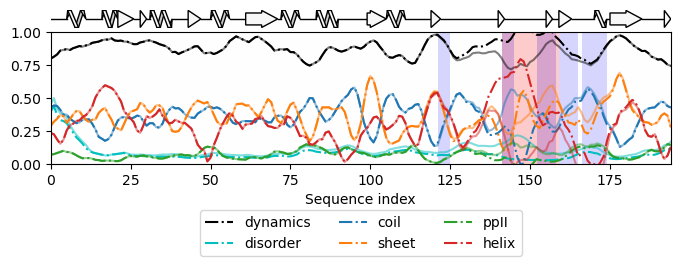

In [5]:
# --- Get some properties for the wt and optimized protein
#
seqB = workflow.negPdb.get_sequences("pdb-atom")[workflow.negChain]
seqC = result.seq
dfB, dfC = workflow.get_b2b_prediction(seqB, seqC)

# --- Plot the results
#
fig, axs =  plt.subplots(2,1, figsize=(8,2), sharex=True,
                gridspec_kw={"hspace": .05, "height_ratios" : [1,7]})

ax = axs[0]
ax.set_axis_off()
ssa.draw((
    "LLLLLHHHHHHLLLLLHHHHHSSSSSLLSSLHHHHHHHLLLLLSSSSLLLHHHHHHLLLL"
    "LSSSSSSSSSSLHHHHHHLLLLLHHHHHHHLLLLLLLLLSSSSSSHHHHHHLLLLLLLLS"
    "SSLLLLLLLLLLLLLLLLLLSSLLLLLLLLLLLLLSSLLSSSSLLLLLLLHHHHLSSSSS"
    "SSSSSLLLLLLLSSL"), ax=ax)

ax = axs[1]
for attr, colo in attribute_color:
    ax.plot(dfB[attr], color=colo, alpha=.5)
    ax.plot(dfC[attr], color=colo, alpha=1., linestyle="-.", label=attr)
ax.imshow([interfaceA], cmap="bwr_r",  vmin=-1, vmax=1, alpha=.2,
            aspect="auto", extent=(0, len(interfaceA), 0, 1), zorder=1)
ax.imshow([interfaceB], cmap="bwr",  vmin=-1, vmax=1, alpha=.2,
            aspect="auto", extent=(0, len(interfaceB), 0, 1), zorder=1)
ax.set_ylim(ymin=0)
ax.set_xlim([0, len(interfaceA)])
ax.set_xlabel("Sequence index")
ax.legend(loc=9, bbox_to_anchor=(.5,-.3), ncols=3)

## Critical assessment

Here, a fully automated workflow is presented to alter the RBD of Spike S1 
protein, to abrogate binding to an antibody while maintaining binding to ACE2.

The workflow applies sequence-based predictors of biophysical properties to 
alter the biophysical behavior of a certain region in a protein.

While the proposed substitution of a poly-leucin seems artificial and would
likely lead to misfolding artifacts in the protein, the approach still 
demonstrates how residue substitutions can influence the biophysical behavior
of a protein region.

The optimization algorithm could be improved to select for more natural 
sequences. The current implementation merely selects for a sequence that
will likely produce the strongest biophysical change.

## References

1. Kagami LP, Orlando G, Raimondi D, Ancien F, Dixit B, Gavaldá-García J, et al. b2bTools: online predictions for protein biophysical features and their conservation. Nucleic Acids Research. 2021 Jul 2;49(W1):W52–9. 
1. Orlando G, Raimondi D, Codice F, Tabaro F, Vranken W. Prediction of disordered regions in proteins with recurrent Neural Networks and protein dynamics. bioRxiv. 2020 Jan 1;2020.05.25.115253. 
1. Cilia E, Pancsa R, Tompa P, Lenaerts T, Vranken WF. From protein sequence to dynamics and disorder with DynaMine. Nature Communications. 2013 Nov 14;4(1):2741. 